In [1]:
import sys
import os
src_path = os.path.abspath(os.path.join('..', 'src'))
if src_path not in sys.path:
    sys.path.append(src_path)

In [2]:
import numpy as np
from sklearn.datasets import make_blobs
import pandas as pd

np.random.seed(42)

In [3]:
X, y, centers = make_blobs(
    n_samples=300000,
    centers=5,
    cluster_std=4.5,
    return_centers=True,
    center_box=(-25.0, 25.0),
    random_state=75
)

In [4]:
data = pd.DataFrame(X, columns=[f'x{i+1}' for i in range(2)])
data['y'] = y

In [5]:
import seaborn as sns

<Axes: xlabel='x1', ylabel='x2'>

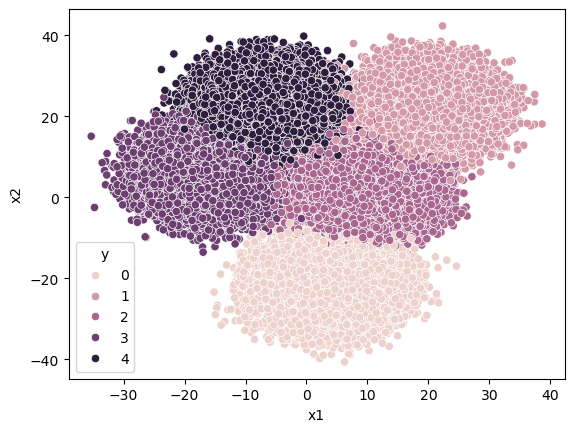

In [6]:
sns.scatterplot(x=data.x1, y=data.x2, hue=data.y)

In [7]:
from connector import spark_connector

In [8]:
from pyspark.sql import Window
from pyspark.sql import functions as F, types as T
import numpy as np
import pandas as pd

In [9]:
spark_connector?

Init signature:
spark_connector(
    exec_inst: int = 100,
    exec_cores: int = 5,
    aloc_max: int = 500,
    memory_exec: int = 25,
    name: object = 'utopialvo',
    rootdir: object = 'remote_dir_in_hdft',
    enable_graphframes: bool = False,
    enable_clickhouse: bool = False,
    enable_postgres: bool = False,
    dynamic_allocation: bool = False,
    intensive_mode: bool = False,
    marshal_mode: bool = True,
    yarn: bool = True,
) -> None
Docstring:     
Класс стандартного подключения к Spark

exec_inst - количество контейнеров
exec_cores - количество ядер в контейнере
aloc_max - максимальное количество ядер для dynamic_allocation (если он вкл)
memory_exec - количество памяти в контейнере
name - название подключения для упрощения логгирования подключений в кластере
rootdir - корневая папка в HDFS 
enable_graphframes - включить работу с graphframes
enable_clickhouse - включить работу с clickhouse
enable_postgres - включить работу с postgres
dynamic_allocation - включить д

In [10]:
con = spark_connector(exec_inst=2, exec_cores=8, memory_exec=15, enable_graphframes=True, marshal_mode=False, yarn = False)

In [11]:
con.spark

In [12]:
df = con.spark.createDataFrame(data)

In [13]:
from LSH import MultiBucketLSH

In [14]:
lsh = MultiBucketLSH(
    input_cols=["x1", "x2"],
    dim=2,
    num_hashes=35,
    bin_widths=[1.0, 5.0],
    random_proj=False,
    seed=42
)

In [15]:
result_df = lsh.transform(df)

/usr/local/spark/python/pyspark/sql/dataframe.py:168: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(
/usr/local/spark/python/pyspark/sql/pandas/functions.py:407: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


In [16]:
result_df

DataFrame[x1: double, x2: double, y: bigint, bins_0: array<int>, bins_1: array<int>]

In [17]:
result_df.groupBy('bins_1').agg(F.countDistinct('bins_0').alias('count')).orderBy('count', ascending = False).show()

+--------------------+-----+
|              bins_1|count|
+--------------------+-----+
|[-12, 12, 0, 12, ...|   24|
|[-7, 3, -2, 1, -6...|   20|
|[-7, 2, -2, 1, -6...|   20|
|[11, -2, 3, 2, 10...|   20|
|[-5, -11, -6, -17...|   20|
|[-3, -9, -5, -13,...|   19|
|[-9, 3, -2, 1, -8...|   19|
|[-7, 3, -1, 1, -6...|   19|
|[11, -1, 3, 3, 10...|   19|
|[-9, 2, -2, 0, -8...|   19|
|[12, -1, 4, 5, 11...|   19|
|[-8, 3, -2, 1, -7...|   18|
|[-11, 12, 1, 12, ...|   18|
|[6, 6, 4, 11, 6, ...|   18|
|[5, 8, 5, 14, 6, ...|   18|
|[-6, -9, -6, -15,...|   18|
|[5, 8, 5, 14, 6, ...|   18|
|[-6, -9, -6, -15,...|   18|
|[-9, 3, -2, 1, -8...|   18|
|[11, -1, 3, 3, 10...|   18|
+--------------------+-----+
only showing top 20 rows



In [18]:
result_df.groupBy('bins_0').agg(F.countDistinct('bins_1').alias('count')).orderBy('count', ascending = False).show()

+--------------------+-----+
|              bins_0|count|
+--------------------+-----+
|[-24, -38, -24, -...|    1|
|[-47, 60, 8, 64, ...|    1|
|[-77, 63, -2, 56,...|    1|
|[15, -46, -13, -5...|    1|
|[55, -5, 17, 16, ...|    1|
|[57, 32, 34, 70, ...|    1|
|[-3, 34, 13, 46, ...|    1|
|[-30, 6, -8, -4, ...|    1|
|[-61, 55, 1, 52, ...|    1|
|[-12, 4, -3, 2, -...|    1|
|[-45, -35, -31, -...|    1|
|[-20, 10, -3, 6, ...|    1|
|[-29, -35, -25, -...|    1|
|[-12, -37, -20, -...|    1|
|[-43, 14, -9, 2, ...|    1|
|[16, 43, 23, 68, ...|    1|
|[30, 14, 17, 34, ...|    1|
|[1, -54, -22, -75...|    1|
|[51, 21, 26, 52, ...|    1|
|[-27, -43, -27, -...|    1|
+--------------------+-----+
only showing top 20 rows



In [19]:
result_df.join(result_df.groupBy('bins_1').agg(F.countDistinct('bins_0').alias('count')).filter('count > 1').select('bins_1').distinct(), on='bins_1', how='inner').orderBy('bins_1').show()

+--------------------+------------------+------------------+---+--------------------+
|              bins_1|                x1|                x2|  y|              bins_0|
+--------------------+------------------+------------------+---+--------------------+
|[-22, 11, -3, 7, ...| 31.02723362343953|12.802768744757977|  1|[-107, 57, -15, 3...|
|[-22, 11, -3, 7, ...|30.987801063401527|12.798823349019559|  1|[-106, 57, -15, 3...|
|[-22, 13, -3, 9, ...| 31.87645865657958| 17.59409975336077|  1|[-108, 68, -11, 4...|
|[-22, 13, -3, 9, ...| 31.80880712798627|17.606914463278912|  1|[-107, 68, -11, 4...|
|[-22, 15, -2, 12,...|32.743378193334586| 22.41834161979518|  1|[-109, 78, -7, 64...|
|[-22, 15, -2, 12,...|32.684355210597495|22.412865554675534|  1|[-108, 78, -6, 64...|
|[-22, 16, -1, 14,...|  32.2903488960256|24.413467580036222|  1|[-106, 82, -4, 70...|
|[-22, 16, -1, 14,...| 32.36274801177335| 24.45553724703002|  1|[-106, 82, -4, 70...|
|[-21, 12, -3, 9, ...| 30.84797503178091|16.1029843214

In [20]:
con.stop_spark()

time: 2025-05-14 18:10:39.505982
del
stop
